In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyeo import classification as cls

from tpot import TPOTClassifier

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

In [87]:
band_labels = ["ndvi","ci","psri","gndvi","s2_rep","ireci","s2_b", "s2_g", "s2_r", "s2_nir", "hv", "vv", "segs"]

training_data = pd.read_csv("data/training_sigs_12_bands_and_segs.csv", names=
                           ["class"]+band_labels).astype(np.uint32)

In [88]:
training_data

,class,ndvi,ci,psri,gndvi,s2_rep,ireci,s2_b,s2_g,s2_r,s2_nir,hv,vv,segs
0,3,5506,8515,919,5570,715,2301,438,592,603,2081,6223,23284,871026
1,3,4915,7483,1328,5023,722,2266,535,757,779,2285,4225,20804,871026
2,3,3987,6554,2173,4750,726,1948,590,832,1005,2338,3983,14438,49552
3,3,6586,13830,460,5982,722,4148,461,684,560,2721,3785,28567,350575
4,3,6149,13607,690,5820,721,3783,463,677,611,2563,3162,25760,350575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238030,1,6851,16527,320,6417,718,2759,258,354,303,1622,6451,32767,289291
238031,1,6987,15728,570,6512,725,3308,262,412,346,1951,4950,27877,289291
238032,1,6677,14893,376,6123,726,3387,353,496,411,2063,4279,22309,289291
238033,1,6304,13895,662,5972,726,3354,373,534,480,2118,5345,22062,289291


In [89]:
def sample_class(class_df):
    return class_df.sample(150)
    
sampled_data = training_data.groupby('class').apply(sample_class).reset_index(1, drop=True)

In [90]:
sampled_data

,class,ndvi,ci,psri,gndvi,s2_rep,ireci,s2_b,s2_g,s2_r,s2_nir,hv,vv,segs
class,,,,,,,,,,,,,,
1,1,6794,20014,73,5964,721,3662,352,482,364,1907,9480,29663,710431
1,1,7572,20687,172,6930,723,5733,322,470,358,2592,3750,15347,635512
1,1,7146,21115,319,6471,728,4902,344,515,400,2404,4841,19462,684828
1,1,7632,26649,175,6750,730,6218,305,484,335,2495,11618,32767,712161
1,1,5749,11826,616,5630,720,2076,363,464,448,1660,6809,23689,289992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,812,1397,5662,3537,714,407,764,1214,2161,2543,32767,32767,354784
7,7,979,1588,2898,2296,757,468,1371,1513,1984,2415,4824,24346,41744
7,7,949,1231,4437,2730,666,484,1038,1535,2222,2688,3685,15305,354690


KeyboardInterrupt: 

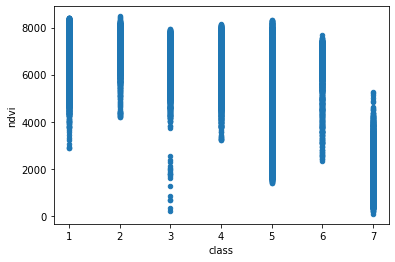

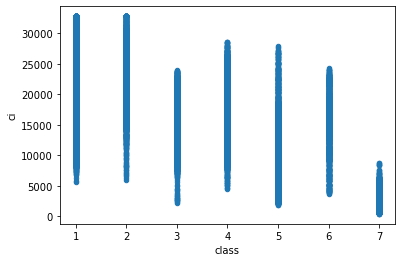

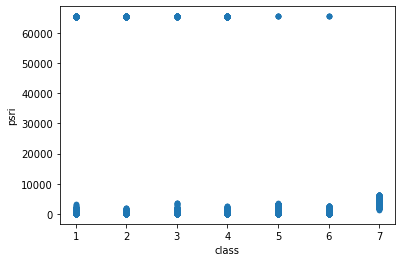

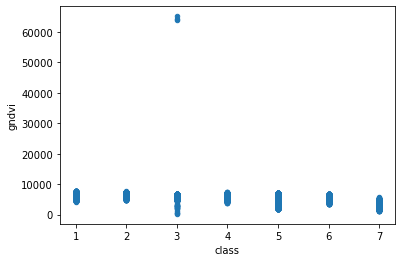

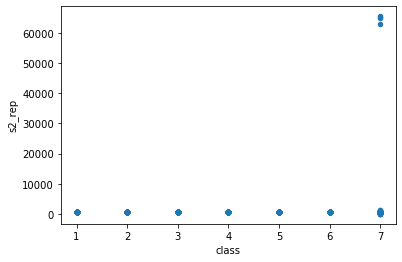

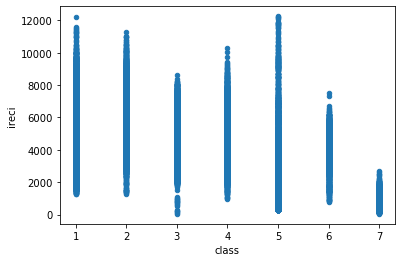

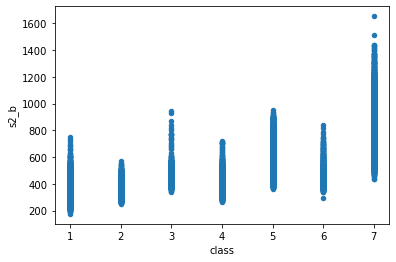

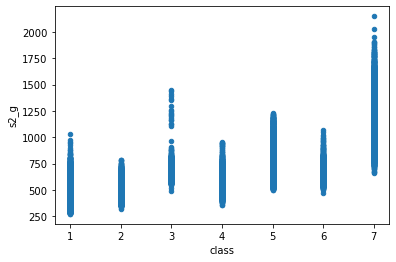

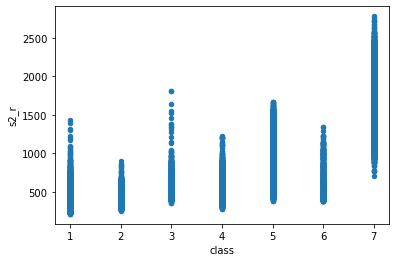

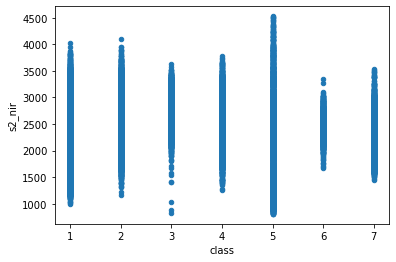

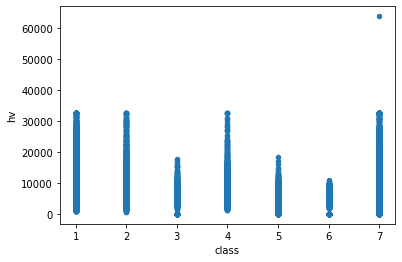

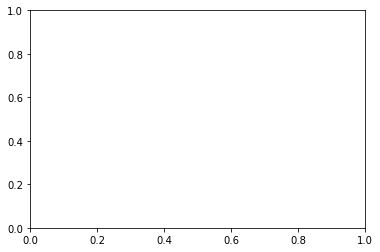

In [15]:
for i in range(0,12):
    training_data.plot.scatter(x='class', y=band_labels[i])

In [91]:
labels = sampled_data['class']
features = sampled_data.loc[:,'ndvi':]

In [93]:
features

,ndvi,ci,psri,gndvi,s2_rep,ireci,s2_b,s2_g,s2_r,s2_nir,hv,vv,segs
class,,,,,,,,,,,,,
1,6794,20014,73,5964,721,3662,352,482,364,1907,9480,29663,710431
1,7572,20687,172,6930,723,5733,322,470,358,2592,3750,15347,635512
1,7146,21115,319,6471,728,4902,344,515,400,2404,4841,19462,684828
1,7632,26649,175,6750,730,6218,305,484,335,2495,11618,32767,712161
1,5749,11826,616,5630,720,2076,363,464,448,1660,6809,23689,289992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,812,1397,5662,3537,714,407,764,1214,2161,2543,32767,32767,354784
7,979,1588,2898,2296,757,468,1371,1513,1984,2415,4824,24346,41744
7,949,1231,4437,2730,666,484,1038,1535,2222,2688,3685,15305,354690


In [95]:
searcher = TPOTClassifier(generations=100, population_size=100, cv=5,n_jobs = -1, verbosity=2, 
                         periodic_checkpoint_folder = "models/tpot_intrim")
searcher.fit(f_train, l_train)
searcher.score(f_test, l_test)

Generation 1 - Current best internal CV score: 0.7189645148846266
Generation 2 - Current best internal CV score: 0.7293047938221294
Generation 3 - Current best internal CV score: 0.7343560736123228
Generation 4 - Current best internal CV score: 0.7343560736123228
Generation 5 - Current best internal CV score: 0.7343560736123228
Generation 6 - Current best internal CV score: 0.7343560736123228
Generation 7 - Current best internal CV score: 0.7368824503121763
Generation 8 - Current best internal CV score: 0.7419628985964162
Generation 9 - Current best internal CV score: 0.7419628985964162
Generation 10 - Current best internal CV score: 0.7419628985964162
Generation 11 - Current best internal CV score: 0.7432392752962695
Generation 12 - Current best internal CV score: 0.7432392752962695
Generation 13 - Current best internal CV score: 0.7432392752962695
Generation 14 - Current best internal CV score: 0.7432392752962695
Generation 15 - Current best internal CV score: 0.8259339224649885
Gene

0.8517110266159695

In [96]:
searcher.export("maybe_overfitted_grad_boost.py")

In [82]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
searcher.export('tpot_v2_nomalised.pkl')
model = RandomForestClassifier(LogisticRegression(RobustScaler(ZeroCount(input_matrix)), C=15.0, dual=True, penalty=l2), bootstrap=True, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=7, min_samples_split=3, n_estimators=100)
model.score(f_test, l_test)

0.6342857142857142

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# Average CV score on the training set was:0.8129780700079303
exported_pipeline = make_pipeline(
    make_union(
        StackingEstimator(estimator=GaussianNB()),
        FunctionTransformer(copy)
    ),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.4, min_samples_leaf=3, min_samples_split=2, n_estimators=100)
)

training_data = training_data[training_data['class'] != 5]
labels = training_data['class']
features = training_data.loc[:,'band_1':].drop(["segment_id"], axis = 1)


#model = exported_pipeline.fit(features, labels)
#joblib.dump(model, "extra_trees_no_builtup.pkl")

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12
0,7573,24811,47.0,6821,724,6674,382,522,381,2767,8229,30929
1,7977,31234,48.0,7248,726,9051,374,516,363,3235,4049,23925
2,7172,22947,145.0,6467,723,5725,401,553,425,2595,7395,28018
3,7807,26235,107.0,6919,724,9087,428,627,423,3455,8403,23644
4,7722,26577,48.0,6921,724,8942,444,627,442,3447,9040,31507
...,...,...,...,...,...,...,...,...,...,...,...,...
14282,7301,25182,61.0,6574,723,5050,337,445,336,2160,8320,24300
14283,7301,25182,61.0,6574,723,5050,337,445,336,2160,8320,24300
14284,7330,23172,101.0,6497,724,5368,370,509,369,2398,5510,28402
14285,6551,16785,302.0,6059,723,3944,420,560,476,2284,6139,21726


In [70]:
import joblib
from pyeo.classification import classify_image
from pyeo.filesystem_utilities import init_log
init_log("model_exploration.log")
image_path = "data/s2_20180219_testsite_vegIndex_s1_clipped.tif"
output_path = "outputs/extra_trees_test.tif"
model_path = "last_tested_model.pkl"
joblib.dump(model, model_path)
classify_image(image_path, model_path, output_path, apply_mask=False)

2019-10-02 10:33:36,101: INFO: ****PROCESSING START****
2019-10-02 10:33:36,151: INFO: Classifying file: data/s2_20180219_testsite_vegIndex_s1_clipped.tif
2019-10-02 10:33:36,154: INFO: Saved model     : last_tested_model.pkl
2019-10-02 10:33:36,157: WARNING: Sklearn joblib import failed,trying generic joblib
2019-10-02 10:33:36,190: INFO: Created classification image file: outputs/extra_trees_test.tif
2019-10-02 10:33:36,194: INFO: Reshaping image from GDAL to Scikit-Learn dimensions
2019-10-02 10:33:36,194: INFO: Finding good pixels without missing values
2019-10-02 10:33:36,197: INFO: image_array.shape = (1329696, 12)
2019-10-02 10:33:36,652: INFO: No. good values: 1323130
2019-10-02 10:33:36,652: INFO: Not worth filtering nodata, skipping.
2019-10-02 10:33:36,653: INFO:    All  samples: 1329696
2019-10-02 10:33:36,663: INFO:    Good samples: 1329696
2019-10-02 10:33:36,669: INFO:    Number of chunks 10 Chunk size 132969 Chunk residual 6
2019-10-02 10:33:36,671: INFO:    Classifying

'outputs/extra_trees_test.tif'